This notebook's goal is to predict a heart rate from a simulated photoplethysmographic signal.   
The Matlab simulator used to generate those PPG signal is the one published on Elgendi's GitHub (link below).   
https://github.com/Elgendi/PPG-Synthesis

In [233]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import keras
import numpy as np
import cv2
import tensorflow as tf
import scipy.signal
import scipy.io
import shap

from lime import lime_tabular
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from skimage.segmentation import mark_boundaries
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Input, BatchNormalization, Conv1D, MaxPooling1D
from keras.layers import Dropout, Dense, Flatten

tf.compat.v1.disable_eager_execution()

Data   
----

In [378]:
# Number of signals
n_sig = 500
# Number of sampling points for each signal
n_samp = 500
# Signal frequency
f_sig = 1
# Sampling frequency
f_samp = 100
# Signal max frequency
f_max = 12

In [466]:
# num_signals : number of "signals" images we want to generate
# add_noise : True if we want to add white noise to the signal
# padding : space we want to leave free at top 
#           and bottom of the signal inside the image
# img_size : width = number of sample of the signal, sampled at 100 Hz

def generate_img_sig(num_signals:int, add_noise:bool = False, padding:int = 25, 
                   img_size:tuple = (250, 250)):
    num_samples = img_size[1]
    height = img_size[0]
    fsig = f_sig
    df = fsig / (num_signals/10)    # frequency step for 10 signals per frequency
    t = np.linspace(0, num_samples/f_samp, num_samples)
    img_ds = np.zeros((num_signals, height, num_samples, 3))
    sig_ds = np.zeros((num_signals, num_samples))

    for i in range(num_signals):
        f = fsig + (i//10)*df      # Increasing frequency every 10 signals
        phi = 2*np.pi*(i%10)/10     # Increasing phase for each signals
        sig = np.sin(2*np.pi*f*t + phi)
        if add_noise:               # Noise added with Matlab
            A = 0.2 + 2*(i%10)/100
            noise = A*np.random.normal(0, 1, num_samples)
            sig += noise
        img = sig_to_img(sig, padding, img_size)
        img_ds[i] = img
        sig_ds[i, :] = sig

    return (img_ds, sig_ds)


# signal : signal we want to transform into image
# padding : space we want to leave free at top 
#           and bottom of the signal inside the image
# img_size : width is the number of samples constituting each signal

def sig_to_img(signal:np.array, padding:int = 25, img_size:int = (250, 250)):
    signal = signal - np.mean(signal)
    height = img_size[0]
    num_samples = img_size[1]
    offset = height // 2
    row_high = height - padding
    middle = (row_high - padding) // 2
    img = np.zeros(img_size) + 255
    last_row = offset
    for i in range(num_samples):
        row = int(offset - (signal[i] * middle))
        if row >= height:
            row = height - 1
        elif row < 0:
            row = 0
        if last_row < row:
            img[last_row:row, i] = 0
        elif last_row > row:
            img[row:last_row, i] = 0
        else:
            img[row, i] = 0
        last_row = row
    img = cv2.cvtColor(np.expand_dims(img, -1).astype("float32"), cv2.COLOR_GRAY2RGB)

    return img
    

In [6]:
# pure_img, pure_sig = generate_img_sig(n_sig)

# scipy.io.savemat("pure_sig.mat", {"pure_sig":pure_sig})

In [511]:
x = scipy.io.loadmat("x.mat")
x = x["x"]
x = np.expand_dims(x, axis = -1)

y = scipy.io.loadmat("y.mat")
y = y["y"][0]

x_hl = scipy.io.loadmat("x_hl.mat")
x_hl = x_hl["x_hl"]
x_hl = np.expand_dims(x_hl, axis = -1)

y_hl = scipy.io.loadmat("y_hl.mat")
y_hl = y_hl["y_hl"][0]

In [512]:
x_train, x_, y_train, y_ = train_test_split(x, y, test_size = 0.2,
                                        random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_, y_, test_size = 0.5,
                                                random_state = 42)

CNN 1D   
------

In [513]:
input_shape = (x_train.shape[1], x_train.shape[2])

model = Sequential()

model.add(Conv1D(filters = 32, kernel_size = 5,
                 input_shape = input_shape,
                 activation = "relu", padding = "same"))
model.add(Conv1D(filters = 16, kernel_size = 10,
                 activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size = 5))

model.add(Conv1D(filters = 32, kernel_size = 15,
                activation = "relu", padding = "same"))

model.add(Dropout(rate = 0.3))

model.add(Flatten())
model.add(Dense(units = 50))
model.add(Dense(units = 1))

# Compilation of model
model.compile(loss = "mean_squared_error",
        optimizer = keras.optimizers.Adam(learning_rate = 0.01), 
        metrics = ["mean_squared_error"])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_53 (Conv1D)          (None, 500, 32)           192       
                                                                 
 conv1d_54 (Conv1D)          (None, 500, 16)           5136      
                                                                 
 batch_normalization_19 (Bat  (None, 500, 16)          64        
 chNormalization)                                                
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 100, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_55 (Conv1D)          (None, 100, 32)           7712      
                                                                 
 dropout_18 (Dropout)        (None, 100, 32)         

In [514]:
# Fitting model
epochs = 20
H = model.fit(x_train, y_train, 
        validation_data = (x_val, y_val), epochs = epochs)

Train on 800 samples, validate on 100 samples
Epoch 1/20
800/800 [==============================] - ETA: 0s - loss: 483.1527 - mean_squared_error: 483.1526

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


800/800 [==============================] - 7s 9ms/sample - loss: 483.1527 - mean_squared_error: 483.1526 - val_loss: 2883.5627 - val_mean_squared_error: 2883.5627
Epoch 2/20
800/800 [==============================] - 2s 2ms/sample - loss: 48.3765 - mean_squared_error: 48.3765 - val_loss: 2437.7664 - val_mean_squared_error: 2437.7664
Epoch 3/20
800/800 [==============================] - 2s 2ms/sample - loss: 19.9975 - mean_squared_error: 19.9975 - val_loss: 2149.1820 - val_mean_squared_error: 2149.1821
Epoch 4/20
800/800 [==============================] - 2s 2ms/sample - loss: 21.3556 - mean_squared_error: 21.3556 - val_loss: 1742.1454 - val_mean_squared_error: 1742.1453
Epoch 5/20
800/800 [==============================] - 2s 2ms/sample - loss: 14.2635 - mean_squared_error: 14.2635 - val_loss: 1611.7981 - val_mean_squared_error: 1611.7981
Epoch 6/20
800/800 [==============================] - 1s 2ms/sample - loss: 17.8011 - mean_squared_error: 17.8011 - val_loss: 1120.9273 - val_mean_sq

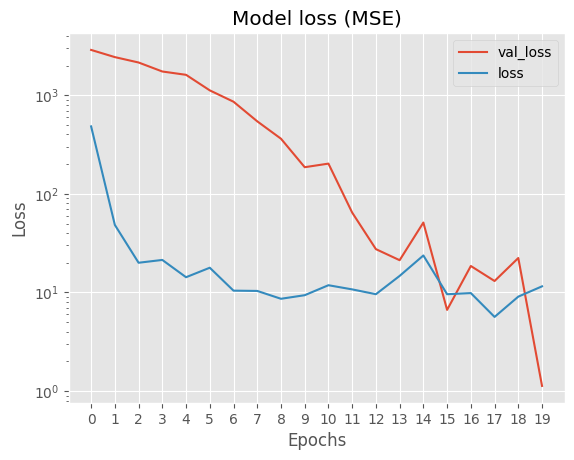

In [611]:
plt.figure()
plt.plot(H.history["val_loss"], label = "val_loss")
plt.plot(H.history["loss"], label = "loss")
plt.xticks(range(0, epochs))
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model loss (MSE)")
plt.legend()
plt.show()

In [591]:
# Predicting
y_pred = model.predict(x_test)
for i in range(5, 10):
    print(f"Truth: {y_test[i]}\nPredicted: {y_pred[i, 0]}\n")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

Truth: 88
Predicted: 89.02342224121094

Truth: 49
Predicted: 48.87419128417969

Truth: 81
Predicted: 80.75011444091797

Truth: 93
Predicted: 94.0672836303711

Truth: 72
Predicted: 72.53304290771484

MSE: 0.977000892162323


In [612]:
# Testing with heart rate out of training boundaries

pred_hl = model.predict(x_hl)
for i in range(5):
    print(f"Truth: {y_hl[i]}\nPredicted: {pred_hl[i, 0]}\n")
print(f"MSE: {mean_squared_error(y_hl, pred_hl)}")

Truth: 35
Predicted: 37.48729705810547

Truth: 107
Predicted: 87.69071960449219

Truth: 97
Predicted: 87.13387298583984

Truth: 40
Predicted: 41.841339111328125

Truth: 32
Predicted: 35.20902633666992

MSE: 337.2652587890625


Best results for now   
Can't predict frequencies higher than 85

LIME   
----

In [518]:
explainer_lime = lime_tabular.RecurrentTabularExplainer(training_data = x_train,
                    mode = "regression", feature_names = ["val_feat"],
                    verbose = True)

In [620]:
n = np.random.choice(x_hl.shape[0])
sig_train = x_train[n]
f_sig_train = y_train[n]

sig_test = x_test[n]
f_sig_test = y_test[n]

sig_hl = x_hl[n]
f_sig_hl = y_hl[n]

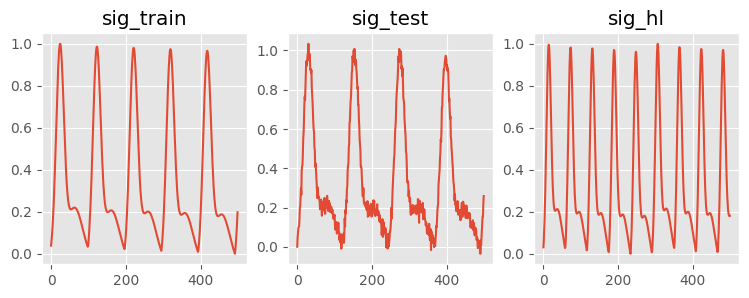

In [621]:
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 
axs[0].plot(sig_train)
axs[0].set_title("sig_train")
axs[1].plot(sig_test)
axs[1].set_title("sig_test")
axs[2].plot(sig_hl)
axs[2].set_title("sig_hl")
plt.show()

In [579]:
def show_exp_1D(exp, sig, weigth):
    img = sig_to_img(sig, img_size = (sig_hl.shape[0], sig_hl.shape[0]))
    m = [exp.as_map()[key] for key in exp.as_map()][0]
    for i in range(len(m)):
        pix = m[i][0]
        val = m[i][1]
        if val > weigth:
            for p in range(img.shape[0]):
                if img[p, pix, 0] != 255:
                    img[p, pix, 0] = 125
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Intercept 19.750071614048032
Prediction_local [60.24193192]
Right: 60.241932
Pulse rate: 61


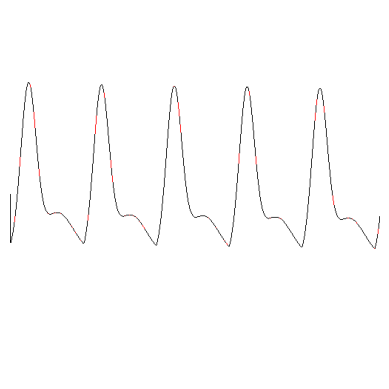

In [622]:
exp_train = explainer_lime.explain_instance(sig_train, 
                    model.predict, 
                    num_features = len(sig_train), 
                    num_samples = 200, 
                    model_regressor = LinearRegression())
print(f"Pulse rate: {f_sig_train}")
show_exp_1D(exp_train, sig_train, 0.3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Intercept 23.038662030902913
Prediction_local [48.87419128]
Right: 48.87419
Pulse rate: 49


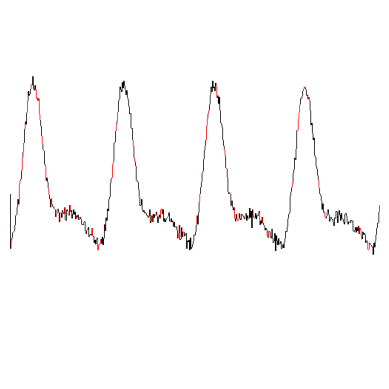

In [626]:
exp_test = explainer_lime.explain_instance(sig_test, model.predict, 
                    num_features = len(sig_test), num_samples = 200,
                    model_regressor = LinearRegression())
print(f"Pulse rate: {f_sig_test}")
show_exp_1D(exp_test, sig_test, 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Intercept 11.45779246638104
Prediction_local [85.89059448]
Right: 85.890594
Pulse rate: 103


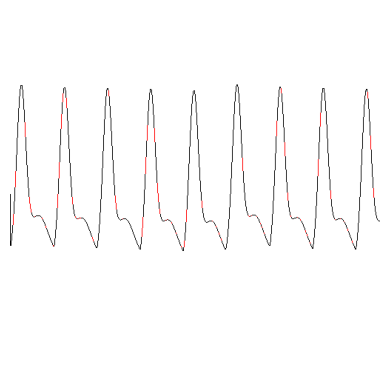

In [627]:
exp_hl = explainer_lime.explain_instance(sig_hl, model.predict, 
                    num_features = len(sig_hl), num_samples = 200, 
                    model_regressor = LinearRegression())
print(f"Pulse rate: {f_sig_hl}")
show_exp_1D(exp_hl, sig_hl, 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Intercept 24.198895796664022
Prediction_local [48.60083389]
Right: 48.600834


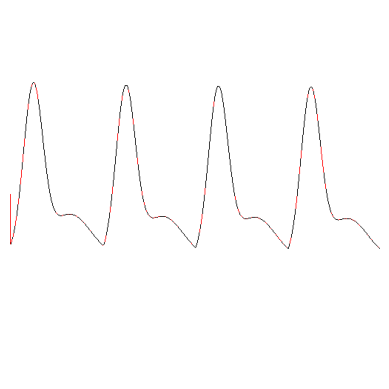

Intercept 23.36173570069012
Prediction_local [48.61094284]
Right: 48.610943


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


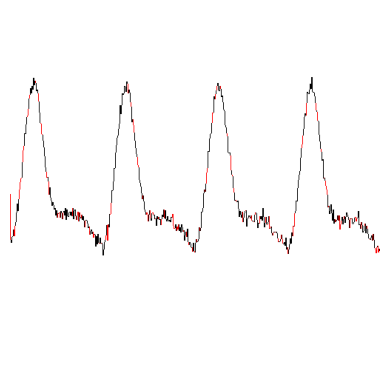

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Intercept 18.959209001729175
Prediction_local [62.588871]
Right: 62.58887


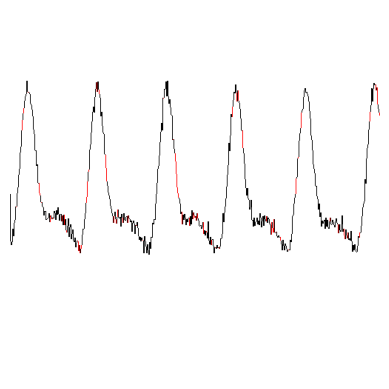

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Intercept 23.29765844966647
Prediction_local [48.82889175]
Right: 48.82889


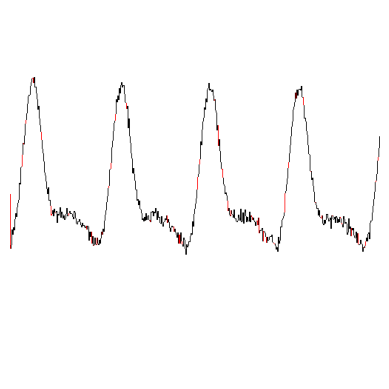

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Intercept 15.368265298590254
Prediction_local [76.78990173]
Right: 76.7899


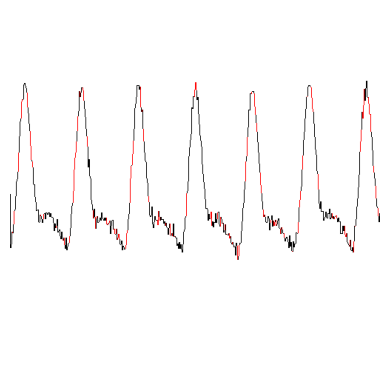

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Intercept 20.964326613178084
Prediction_local [53.63576508]
Right: 53.635765


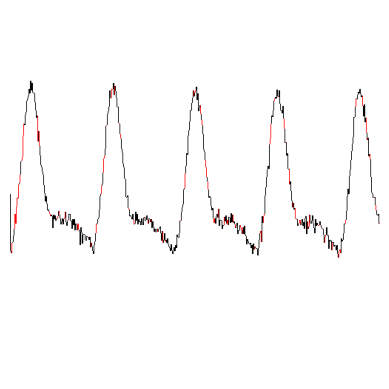

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Intercept 19.851030514564613
Prediction_local [60.24193192]
Right: 60.241932


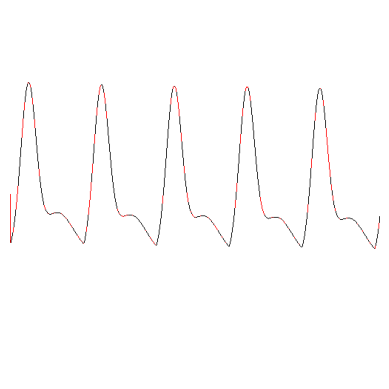

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Intercept 10.995599090889627
Prediction_local [87.62792969]
Right: 87.62793


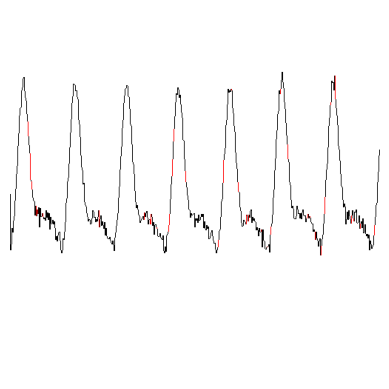

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Intercept 8.230567756905245
Prediction_local [94.84624481]
Right: 94.846245


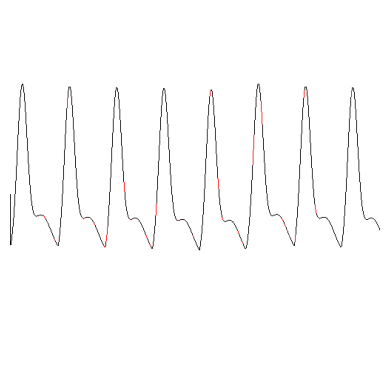

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Intercept 14.712468067751608
Prediction_local [74.93119049]
Right: 74.93119


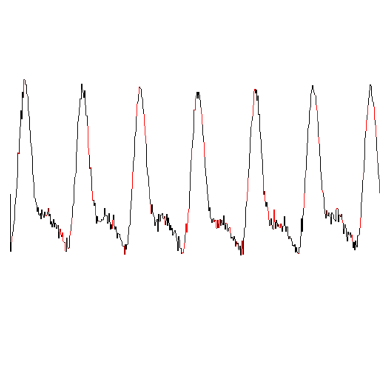

In [630]:
for i in range(10):
    exp_train = explainer_lime.explain_instance(x_train[i], 
                    model.predict, 
                    num_features = len(sig_train), 
                    num_samples = 200, 
                    model_regressor = LinearRegression())
    show_exp_1D(exp_train, x_train[i], 0.15)

In [625]:
# Need to adapt this kind of code to show_exp_1D

# t = np.arange(0, len(sig_hl)/f_samp, 1/f_samp)
# md = {"k" : [t<=0.8],
#         "r": [t>0.8]}
# for c, ma in md.items():
#     for m in ma:
#         plt.plot(t[m], sig_hl[m], c = c)

SHAP   
----

Not enough time to understand how to use SHAP on temporal signals.